In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from time import sleep
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
headers= {
    'Host': 'stats.nba.com', 
    'Connection': 'keep-alive', 
    'Accept': 'application/json, text/plain, */*', 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
    'Referer': 'https://stats.nba.com/', 
    'Accept-Encoding': 'gzip, deflate, br', 
    'Accept-Language': 'en-US,en;q=0.9',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
}

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=zorder)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=zorder)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=zorder)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [6]:
from nba_api.stats.endpoints.playerdashptshotdefend import PlayerDashPtShotDefend

LESS_SIX = "LESS_THAN_SIX"
SIX_TEN = "SIX_TEN"
TEN_FIFTEEN = "TEN_FIFTEEN"
GREATER_FIFTEEN = "GREATER_FIFTEEN"
THREE_POINTER = "THREE_POINTER"

In [7]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'


In [8]:
def_dist_keys = [LESS_SIX, SIX_TEN, TEN_FIFTEEN, GREATER_FIFTEEN, THREE_POINTER]

def get_defend_data(player_id, date_to="", date_from="", per_game: bool=False, season = "2019-20"):
    defend_data = PlayerDashPtShotDefend(player_id=player_id, team_id=0, date_from_nullable=date_from, date_to_nullable=date_to, per_mode_simple='PerGame' if per_game else 'Totals', season=season)
    
    defend_df = defend_data.get_data_frames()[0]
    
    less_than_10 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 10 Ft'].iloc[0]
    less_than_6 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 6 Ft'].iloc[0]
    greater_than_15 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Greater Than 15 Ft'].iloc[0]
    two_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '2 Pointers'].iloc[0]
    three_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '3 Pointers'].iloc[0]

    greater_fifteen_two_fga = greater_than_15.D_FGA - three_point.D_FGA
    greater_fifteen_two_fgm = greater_than_15.D_FGM - three_point.D_FGM

    ten_fifteen_fga = two_point.D_FGA - greater_fifteen_two_fga - less_than_10.D_FGA
    ten_fifteen_fgm = two_point.D_FGM - greater_fifteen_two_fgm - less_than_10.D_FGM

    six_ten_fga = less_than_10.D_FGA - less_than_6.D_FGA
    six_ten_fgm = less_than_10.D_FGM - less_than_6.D_FGM
    
    made_dict = {
        LESS_SIX: less_than_6.D_FGM,
        SIX_TEN: six_ten_fgm,
        TEN_FIFTEEN: ten_fifteen_fgm,
        GREATER_FIFTEEN: greater_fifteen_two_fgm,
        THREE_POINTER: three_point.D_FGM
    }
    attempt_dict = {
        LESS_SIX: less_than_6.D_FGA,
        SIX_TEN: six_ten_fga,
        TEN_FIFTEEN: ten_fifteen_fga,
        GREATER_FIFTEEN: greater_fifteen_two_fga,
        THREE_POINTER: three_point.D_FGA
    }
    return made_dict, attempt_dict
    
    

team_categories = [
    'Overall',
    '3 Pointers',
    '2 Pointers',
    'Less Than 6Ft',
    'Less Than 10Ft',
    'Greater Than 15Ft'
]

def get_team_defense_df(defense_category, season='2019-20'):
    url = f"https://stats.nba.com/stats/leaguedashptteamdefend?Conference=&DateFrom=&DateTo=&DefenseCategory={defense_category}&Division=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&Season={season}&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision="
    resp = requests.get(url=url, headers=headers)
    data_dict = resp.json()
    return pd.DataFrame(data=data_dict['resultSets'][0]['rowSet'], columns=data_dict['resultSets'][0]['headers'])

def get_league_averages(season = '2019-20'):
    avg_dict = {}

    category_dict = {}
    for category in team_categories:
        category_dict[category] = get_team_defense_df(defense_category=category, season=season)
        sleep(0.25)

    averaged_dicts = {}
    for category in category_dict:
        averaged_dicts[category] = category_dict[category].mean()

    greater_fifteen_two_fga_avg = averaged_dicts['Greater Than 15Ft'].FGA_GT_15 - averaged_dicts['3 Pointers'].FG3A
    greater_fifteen_two_fgm_avg = averaged_dicts['Greater Than 15Ft'].FGM_GT_15 - averaged_dicts['3 Pointers'].FG3M

    ten_fifteen_fga_avg = averaged_dicts['2 Pointers'].FG2A - greater_fifteen_two_fga_avg - averaged_dicts['Less Than 10Ft'].FGA_LT_10
    ten_fifteen_fgm_avg = averaged_dicts['2 Pointers'].FG2M - greater_fifteen_two_fgm_avg - averaged_dicts['Less Than 10Ft'].FGM_LT_10

    six_ten_fga_avg = averaged_dicts['Less Than 10Ft'].FGA_LT_10 - averaged_dicts['Less Than 6Ft'].FGA_LT_06
    six_ten_fgm_avg = averaged_dicts['Less Than 10Ft'].FGM_LT_10 - averaged_dicts['Less Than 6Ft'].FGM_LT_06
    
    avg_dict = {
        LESS_SIX: averaged_dicts['Less Than 6Ft'].FGM_LT_06 / averaged_dicts['Less Than 6Ft'].FGA_LT_06,
        SIX_TEN: six_ten_fgm_avg / six_ten_fga_avg,
        TEN_FIFTEEN: ten_fifteen_fgm_avg / ten_fifteen_fga_avg,
        GREATER_FIFTEEN: greater_fifteen_two_fgm_avg / greater_fifteen_two_fga_avg,
        THREE_POINTER: averaged_dicts['3 Pointers'].FG3M / averaged_dicts['3 Pointers'].FG3A
    }
    return avg_dict

from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path

def get_six_feet_arc(color):
    vertices = [
        [40, -47.5],
        [140, 96],
        [-139, 98],
        [-40, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_six_ten_feet_arc(color):
    vertices = [
        [-90, -47.5],
        [-162, 150],
        [162, 150],
        [90, -47.5],
        [38, -47.5],
        [140, 96],
        [-139, 98],
        [-38, -47.5],   
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_ten_fifteen_arc(color):
    vertices = [
        [-144, -47.5],
        [-200, 215],
        [200, 215],
        [144, -47.5],
        [90, -47.5],
        [162, 150],
        [-162, 150],
        [-90, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)
    
def get_greater_fifteen(color):
    vertices = [
        [-220, -47.5],
        [-220, 90.5],
        [-130, 285],
        [130, 285],
        [220, 90.5],
        [220, -47.5],
        [144, -47.5],
        [200, 215],
        [-200, 215],
        [-144, -47.5],
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_three_point_area(color):
    vertices = [
        [-250, -47.5],
        [-220, -47.5],
        [-220, 90.5],
        [-142, 285],
        [142, 285],
        [220, 90.5],
        [220, -47.5],
        [250, -47.5],
        [250, 160],
        [190, 370],
        [-190, 370],
        [-250, 160]
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4,
            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=3, lw=0)

In [9]:
def plot_texts(ax, made_dict, attempt_dict, six_pct, six_ten_pct, 
               ten_fifteen_pct, greater_fifteen_pct, three_pointer_pct, is_per_game=False):
    alpha = 0.6
    if not is_per_game:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]} / {attempt_dict[LESS_SIX]}\n{six_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]} / {attempt_dict[SIX_TEN]}\n{six_ten_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]} / {attempt_dict[TEN_FIFTEEN]}\n{ten_fifteen_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]} / {attempt_dict[GREATER_FIFTEEN]}\n{greater_fifteen_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]} / {attempt_dict[THREE_POINTER]}\n{three_pointer_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
    else:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]:.2f} / {attempt_dict[LESS_SIX]:.2f}\n{six_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]:.2f} / {attempt_dict[SIX_TEN]:.2f}\n{six_ten_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]:.2f} / {attempt_dict[TEN_FIFTEEN]:.2f}\n{ten_fifteen_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]:.2f} / {attempt_dict[GREATER_FIFTEEN]:.2f}\n{greater_fifteen_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]:.2f} / {attempt_dict[THREE_POINTER]:.2f}\n{three_pointer_pct*100:.2f}%", fontsize=18,
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})




def plot_for_player(player_id, team_id, title, date_from="", date_to="", is_per_game=False, season='2019-20'):
    fig, ax = plt.subplots(figsize=(20, 20))
    # colors_dict = {0:'red', 1:'green'}
    made_dict, attempt_dict = get_defend_data(player_id=player_id, date_from=date_from, date_to=date_to, per_game=is_per_game, season=season)
    league_average = get_league_averages(season=season)

    texts = []
    output_list = []

    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], n_colors=21, as_cmap=False)
    bin_res = {item: index for index, item in enumerate(list(range(-10, 11, 1)))}
    
    six_pct = made_dict[LESS_SIX]/attempt_dict[LESS_SIX]
    six_ten_pct = made_dict[SIX_TEN]/attempt_dict[SIX_TEN]
    ten_fifteen_pct = made_dict[TEN_FIFTEEN]/attempt_dict[TEN_FIFTEEN]
    greater_fifteen_pct = made_dict[GREATER_FIFTEEN]/attempt_dict[GREATER_FIFTEEN]
    three_pointer_pct = made_dict[THREE_POINTER]/attempt_dict[THREE_POINTER]
    
    six_zone_diff = np.clip((six_pct - league_average[LESS_SIX])*100,-10, 10)
    six_ten_diff = np.clip((six_ten_pct - league_average[SIX_TEN])*100,-10, 10)
    ten_fifteen_diff = np.clip((ten_fifteen_pct - league_average[TEN_FIFTEEN])*100,-10, 10)
    greater_fifteen_two_diff = np.clip((greater_fifteen_pct - league_average[GREATER_FIFTEEN])*100,-10, 10)
    three_diff = np.clip((three_pointer_pct - league_average[THREE_POINTER])*100,-10, 10)
    
    plot_texts(ax=ax, made_dict=made_dict, attempt_dict=attempt_dict, six_pct=six_pct, 
               six_ten_pct=six_ten_pct, ten_fifteen_pct=ten_fifteen_pct, greater_fifteen_pct=greater_fifteen_pct,
               three_pointer_pct=three_pointer_pct, is_per_game=is_per_game)


    # GREATER THAN 15
    ax.add_patch(get_greater_fifteen(color=cmap[bin_res[int(greater_fifteen_two_diff)]]))
    # 10-15 ft
    ax.add_patch(get_ten_fifteen_arc(color=cmap[bin_res[int(ten_fifteen_diff)]]))
    # 6-10 ft
    ax.add_patch(get_six_ten_feet_arc(color=cmap[bin_res[int(six_ten_diff)]]))
    # <6 ft
    ax.add_patch(get_six_feet_arc(color=cmap[bin_res[int(six_zone_diff)]]))
    # 3 pt
    ax.add_patch(get_three_point_area(color=cmap[bin_res[int(three_diff)]]))

    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/{season.split('-')[0]}/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    ax.imshow(img, extent=(132, 252, -47, 41), zorder=7)


    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_white, fontsize=20, ha='center')
    ax.text(x=90, y=365, s="BETTER\nDefending", color=bball_white, fontsize=20)
    ax.scatter(x=130, y=387, s=1000, marker='o', c="#4159E1", edgecolors=bball_white)
    ax.scatter(x=147, y=387, s=1000, marker='o', c="#B0E0E6", edgecolors=bball_white)
    ax.scatter(x=164, y=387, s=1000, marker='o', c="#FFFF99", edgecolors=bball_white)
    ax.scatter(x=181, y=387, s=1000, marker='o', c="#EF3330", edgecolors=bball_white)
    ax.scatter(x=198, y=387, s=1000, marker='o', c="#AB2020", edgecolors=bball_white)
    ax.text(x=201, y=365, s="   WORSE\nDefending", color=bball_white, fontsize=20)


    # Title
    ax.set_title(title, size=36, color=bball_light_orange)
    #adjust_text(texts=texts, expand_points=(1.2, 1.9))
    
    ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.025), (142, -58), frameon=False)
    ax.add_artist(ab)

    #ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (0.88, len(pivoted)+0.5), frameon=False)
    y_coord = -60
    #offset_image.set_offset((1100, 0))
    #ax.add_artist(offset_image)
    ax.text(x=150, y=y_coord, ha='left', s='@daniel_bratulic', size=18, color=bball_light_orange)
    ax.text(x=-220, y=y_coord, ha='left', s='source: nba.com', size=18, color=bball_light_orange)
    
    ax.text(x=-170, y=405, s=f"Numbers (Per Game) in Boxes:", color=bball_white, fontsize=20, ha='center')
    ax.text(x=-170, y=380, s=f"Allowed FGM / Allowed FGA\nAllowed FG%", fontsize=20,
            color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': 0.6, 'edgecolor': 'black', 'boxstyle' : 'round'})

    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange, zorder=7)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    for circle in output_list:    
        ax.add_artist(circle)

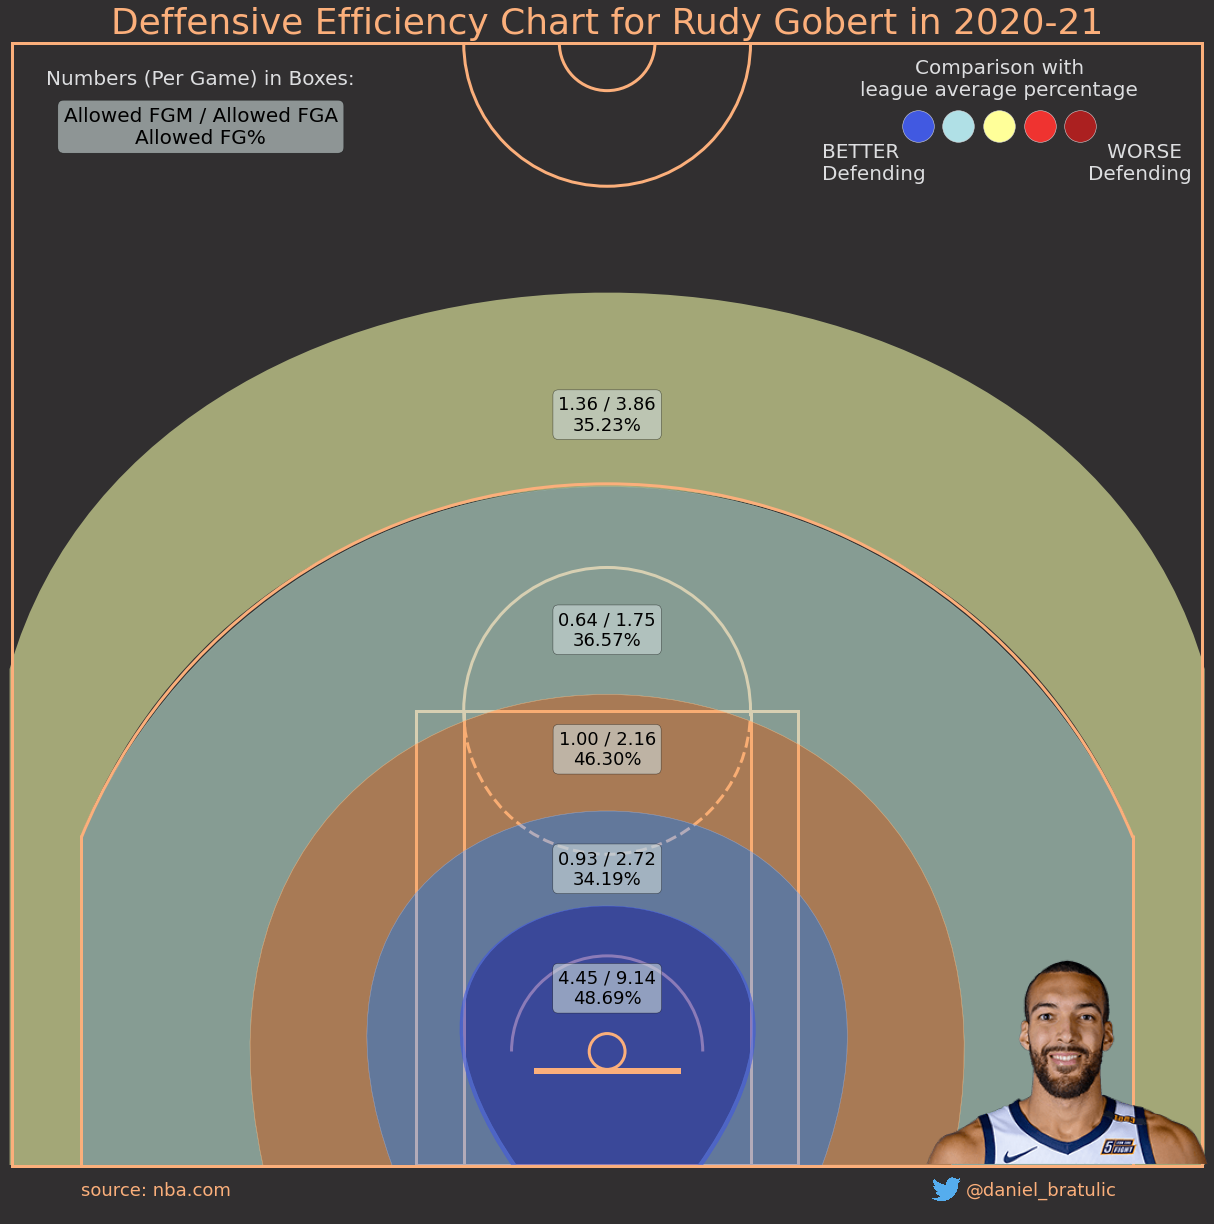

In [12]:
player_name = "Rudy Gobert"
player_id = find_players_by_full_name(player_name)[0]['id']

team_id = find_teams_by_full_name("Utah Jazz")[0]['id']

plot_for_player(player_id=player_id, team_id=team_id, title=f"Deffensive Efficiency Chart for {player_name} in 2020-21", is_per_game=True, season='2020-21')

## Rim Deterrence

In [11]:
shotchart_all = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable='2020-21', timeout=240).get_data_frames()[0]

shotchart_all.LOC_X = -shotchart_all.LOC_X

In [12]:
full_df = pd.read_csv('pbp_analysis/pbp_players/2020-21.csv')
#formatted_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in formatted_df.GAME_ID.astype(str)]

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in full_df.iterrows()]

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})

In [14]:
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [15]:
from nba_api.stats.endpoints.leaguedashptdefend import LeagueDashPtDefend

In [16]:
from nba_api.stats.static.teams import find_team_by_abbreviation

In [17]:
top_defenders = LeagueDashPtDefend(defense_category='Less Than 6Ft').get_data_frames()[0]

In [18]:
top_20 = top_defenders.iloc[:21]

In [19]:
not_interesting = ["Jarrett Allen", "Nikola Vucevic", "Mason Plumlee", "Daniel Theis"]
top_20 = top_20.loc[~top_20.PLAYER_NAME.isin(not_interesting)]

In [20]:
player_teams = {}
for index in range(len(top_20)):
    item = top_20.iloc[index]
    player_teams[item.PLAYER_NAME] = find_team_by_abbreviation(item.PLAYER_LAST_TEAM_ABBREVIATION)['full_name']

In [21]:
target_player_columns = [
    'TEAM_1_PLAYER_1', 'TEAM_1_PLAYER_2', 'TEAM_1_PLAYER_3',
    'TEAM_1_PLAYER_4', 'TEAM_1_PLAYER_5', 'TEAM_2_PLAYER_1',
    'TEAM_2_PLAYER_2', 'TEAM_2_PLAYER_3', 'TEAM_2_PLAYER_4',
    'TEAM_2_PLAYER_5'
]

def get_on_floor(player_id, df):
    queries = [df[key] == player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query | cur
    return df.loc[query]


def get_off_floor(player_id, df):
    queries = [df[key] != player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query & cur
    return df.loc[query]


def check_any(item, player_id):
    for col in target_player_columns:
        if item[col] == player_id:
            return True
    return False


In [22]:
#key = ['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_ZONE_BASIC']
key = ['SHOT_ZONE_BASIC']

defense_dfs = {}

for player in player_teams:
    if player == 'Isaiah Stewart':
        pl_id = 1630191
    else:
        pl_id = find_players_by_full_name(player)[0]['id']
    team_id = find_teams_by_full_name(player_teams[player])[0]['id']
    
    player_on_floor = get_on_floor(pl_id, full_df)
    player_off_floor = get_off_floor(pl_id, full_df)
    player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

    shot_off_court = pd.merge(left=shotchart_all, right=player_off_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    shot_on_court = pd.merge(left=shotchart_all, right=player_on_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    
    non_team_on_court = shot_on_court.loc[shot_on_court.TEAM_ID != team_id]
    non_team_off_court = shot_off_court.loc[shot_off_court.TEAM_ID != team_id]
    
    
    grouped_off = non_team_off_court.groupby(key).sum().reset_index()
    grouped_off = grouped_off.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_off.loc[:, 'FG_PCT'] = grouped_off.SHOT_MADE_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG * 100
    grouped_off.loc[:, 'PCT_OF_SHOTS'] = grouped_off.SHOT_ATTEMPTED_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG.sum() * 100

    grouped_on = non_team_on_court.groupby(key).sum().reset_index()
    grouped_on = grouped_on.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_on.loc[:, 'FG_PCT'] = grouped_on.SHOT_MADE_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG * 100
    grouped_on.loc[:, 'PCT_OF_SHOTS'] = grouped_on.SHOT_ATTEMPTED_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG.sum() * 100
    
    merged_defender_df = pd.merge(left=grouped_on, right=grouped_off, on=key, suffixes=('_ON', '_OFF'))
    defense_dfs[player] = merged_defender_df

In [23]:
mappings = {
    'Above the Break 3': 'ATB_3',
    'In The Paint (Non-RA)': 'PAINT',
    'Corner 3': 'CORNER',
    'Mid-Range': 'MID',
    'Restricted Area': 'RA',
}

In [24]:
print_data = []

for player in defense_dfs:
    df = defense_dfs[player]
    cur_dict = {
        'PLAYER': player
    }
    for key in mappings:
        if key == 'Corner 3':
            cur_df = df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')].iloc[0]
        else:
            cur_df = df.loc[df.SHOT_ZONE_BASIC == key].iloc[0]
        value = mappings[key]
        cur_dict[f"{value}_FG_RATE_ON"] = round(cur_df.PCT_OF_SHOTS_ON, 2)
        cur_dict[f"{value}_FG_RATE_OFF"] = round(cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_RATE_DIFF"] = round(cur_df.PCT_OF_SHOTS_ON - cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_PCT_ON"] = round(cur_df.FG_PCT_ON, 2)
        cur_dict[f"{value}_FG_PCT_OFF"] = round(cur_df.FG_PCT_OFF, 2)
        cur_dict[f"{value}_FG_PCT_DIFF"] = round(cur_df.FG_PCT_ON - cur_df.FG_PCT_OFF, 2)
    print_data.append(cur_dict)
    """paint = df.loc[df.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'].iloc[0]
    ra = df.loc[df.SHOT_ZONE_BASIC == 'Restricted Area'].iloc[0]
    mid = df.loc[df.SHOT_ZONE_BASIC == 'Mid-Range'].iloc[0]
    print_data.append(
        {
            'PLAYER': player,
            'RA_FG_RATE_ON': round(ra.PCT_OF_SHOTS_ON, 2),
            'RA_FG_RATE_OFF': round(ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_RATE_DIFF': round(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_PCT_ON': round(ra.FG_PCT_ON, 2),
            'RA_FG_PCT_OFF': round(ra.FG_PCT_OFF, 2),
            'RA_FG_PCT_DIFF': round(ra.FG_PCT_ON - ra.FG_PCT_OFF, 2),
            'PAINT_FG_PCT_DIFF': round(paint.FG_PCT_ON - paint.FG_PCT_OFF, 2),
            'MID_FG_PCT_DIFF': round(mid.FG_PCT_ON - mid.FG_PCT_OFF, 2),
            'PAINT_FG_RATE_DIFF': round(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF, 2),
            'MID_FG_RATE_DIFF': round(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF, 2),
        }
    )"""
    """
    print(f"RA FG% for {player}: {ra.FG_PCT_ON:.2f}")
    print(f"On-Off Diff in RA for {player}: {(ra.FG_PCT_ON - ra.FG_PCT_OFF):.2f}%; Rate: {(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Paint for {player}: {(paint.FG_PCT_ON - paint.FG_PCT_OFF):.2f}%; Rate: {(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Mid Range for {player}: {(mid.FG_PCT_ON - mid.FG_PCT_OFF):.2f}%; Rate: {(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF):.2f}%")
    print()
    """
print_df = pd.DataFrame(print_data)

In [25]:
ra_diff_sort = print_df.sort_values(by='RA_FG_RATE_DIFF')

In [26]:
ra_diff_sort

,PLAYER,ATB_3_FG_RATE_ON,ATB_3_FG_RATE_OFF,ATB_3_FG_RATE_DIFF,ATB_3_FG_PCT_ON,ATB_3_FG_PCT_OFF,ATB_3_FG_PCT_DIFF,PAINT_FG_RATE_ON,PAINT_FG_RATE_OFF,PAINT_FG_RATE_DIFF,...,MID_FG_RATE_DIFF,MID_FG_PCT_ON,MID_FG_PCT_OFF,MID_FG_PCT_DIFF,RA_FG_RATE_ON,RA_FG_RATE_OFF,RA_FG_RATE_DIFF,RA_FG_PCT_ON,RA_FG_PCT_OFF,RA_FG_PCT_DIFF
0,Rudy Gobert,29.26,26.99,2.27,33.17,35.66,-2.49,22.22,21.84,0.38,...,3.79,40.17,39.08,1.09,25.58,32.18,-6.60,60.00,66.90,-6.90
17,Ivica Zubac,29.91,29.47,0.44,36.11,34.36,1.76,20.82,19.63,1.19,...,3.70,42.37,45.45,-3.09,26.43,31.28,-4.85,63.52,65.14,-1.62
10,Isaiah Stewart,27.70,26.08,1.62,34.60,38.04,-3.44,20.57,18.96,1.61,...,-0.15,42.90,40.69,2.21,29.92,33.79,-3.87,59.39,67.18,-7.79
13,Jonas Valanciunas,30.59,31.53,-0.95,34.43,35.29,-0.86,19.55,18.47,1.09,...,3.22,43.52,38.43,5.09,28.52,30.54,-2.02,62.86,61.21,1.65
1,Jakob Poeltl,27.63,27.92,-0.29,37.83,35.71,2.11,18.35,17.69,0.65,...,1.04,42.96,44.24,-1.29,31.98,33.94,-1.96,58.59,65.06,-6.47
6,Domantas Sabonis,25.45,24.48,0.97,36.83,34.56,2.27,16.78,17.68,-0.90,...,1.84,39.23,36.31,2.93,35.65,37.52,-1.87,62.25,58.04,4.21
4,Brook Lopez,31.98,33.35,-1.37,38.35,35.78,2.57,18.88,17.60,1.28,...,1.25,43.54,42.75,0.79,24.39,26.08,-1.69,58.99,62.78,-3.80
5,Myles Turner,25.63,25.47,0.17,34.93,39.21,-4.28,17.95,15.88,2.06,...,1.20,38.23,35.52,2.71,34.03,35.66,-1.63,58.22,63.91,-5.69
3,Nikola Jokic,30.14,30.56,-0.43,37.12,29.32,7.80,17.17,17.21,-0.04,...,1.92,43.74,33.33,10.41,27.99,29.32,-1.33,67.70,69.84,-2.14
2,Clint Capela,28.12,28.63,-0.51,32.73,37.27,-4.53,17.54,17.14,0.40,...,2.40,42.41,42.17,0.24,31.24,32.30,-1.07,61.37,67.12,-5.75


In [27]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


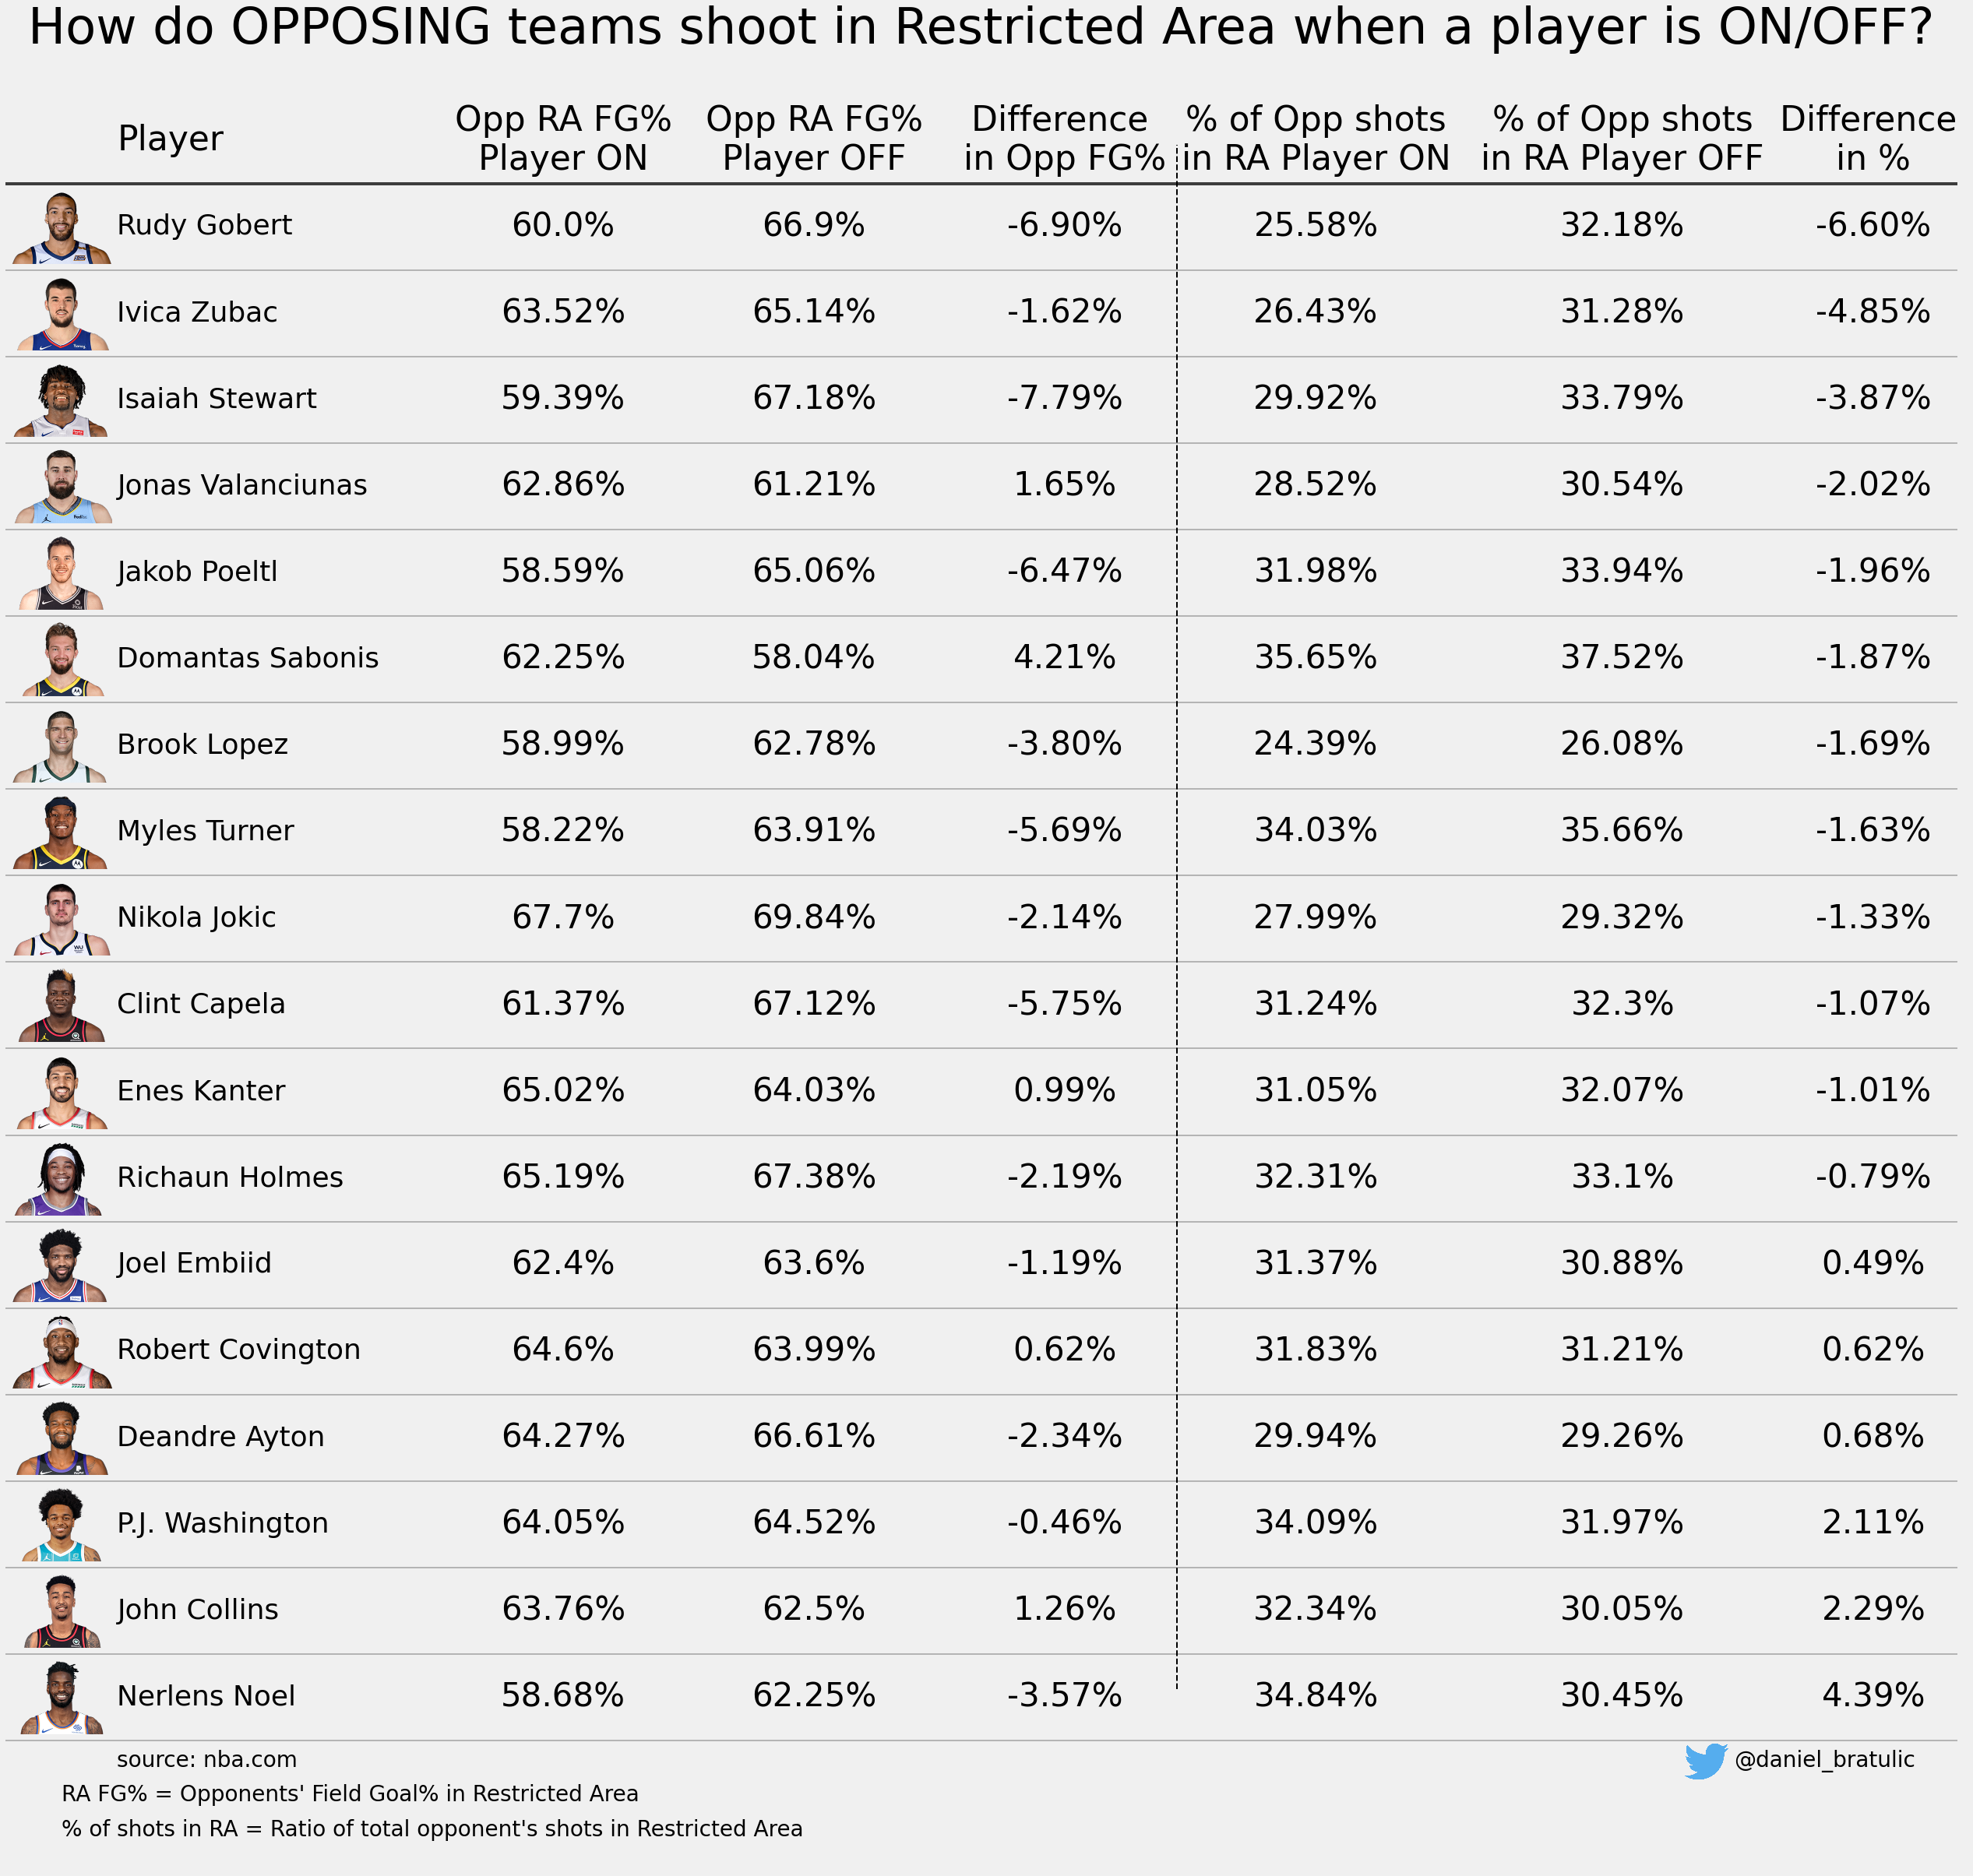

In [28]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 44
title_size = 64
#top = 10

sorted_open_df = ra_diff_sort
top = len(ra_diff_sort)
for i in range(top):
    item = ra_diff_sort.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER)[0]['id']
    except Exception:
        player_id = 1630191
        #continue
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = '#EAE8E8'
    #    rect = Rectangle((-4.5, y_coord + 0.5), width=50, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.2, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=item.PLAYER, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=30, color='#A0A0A0', alpha=0.75, lw=2)

    ax.text(x=2.0, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_ON}%", size=number_size)
    ax.text(x=2.9, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_OFF}%", size=number_size)
    ax.text(x=3.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_DIFF:.2f}%", size=number_size)
    ax.text(x=4.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_ON}%", size=number_size)
    ax.text(x=5.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_OFF}%", size=number_size)
    ax.text(x=6.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_DIFF:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)

ax.text(x=0.4, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=2.0, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer ON", size=font_title)
ax.text(x=2.9, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer OFF", size=font_title)
ax.text(x=3.8, y=top, ha='center', va='center', s="Difference \nin Opp FG%", size=font_title)
ax.text(x=4.7, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player ON", size=font_title)
ax.text(x=5.8, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player OFF", size=font_title)
ax.text(x=6.7, y=top, ha='center', va='center', s="Difference \nin %", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=30, color='black', alpha=0.75, lw=4)
ax.axvline(x=4.2, ymin=0.1, ymax=0.95, lw=2, color='black', ls='--')
ax.set_title("How do OPPOSING teams shoot in Restricted Area when a player is ON/OFF?", size=title_size)
    
ax.set_ylim(bottom=-2, top=top+1)
ax.set_xlim(left=-0, right=7)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (6.1, -0.75), frameon=False)
ax.add_artist(ab)
ax.text(x=6.2, y=-0.8, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.4, y=-0.8, ha='left', s='source: nba.com', size=28)
ax.text(x=0.2, y=-1.2, s="RA FG% = Opponents' Field Goal% in Restricted Area", size=28)
ax.text(x=0.2, y=-1.6, s="% of shots in RA = Ratio of total opponent's shots in Restricted Area", size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

In [33]:
gobert_series = ra_diff_sort.loc[0]

In [34]:
rates = {key: value for key, value in gobert_series.to_dict().items() if 'RATE' in key}

In [35]:
unique_keys = []
for key in rates:
    unique_keys.append(key.split('_FG_RATE')[0])
unique_keys = list(set(unique_keys))

In [36]:
unique_keys = ['RA', 'PAINT', 'MID', 'CORNER', 'ATB_3']

In [37]:
mappings = {
    'Above the Break 3': 'ATB_3',
    'In The Paint (Non-RA)': 'PAINT',
    'Corner 3': 'CORNER',
    'Mid-Range': 'MID',
    'Restricted Area': 'RA',
}

In [38]:
rev_mappings = {value: key for key, value in mappings.items()}

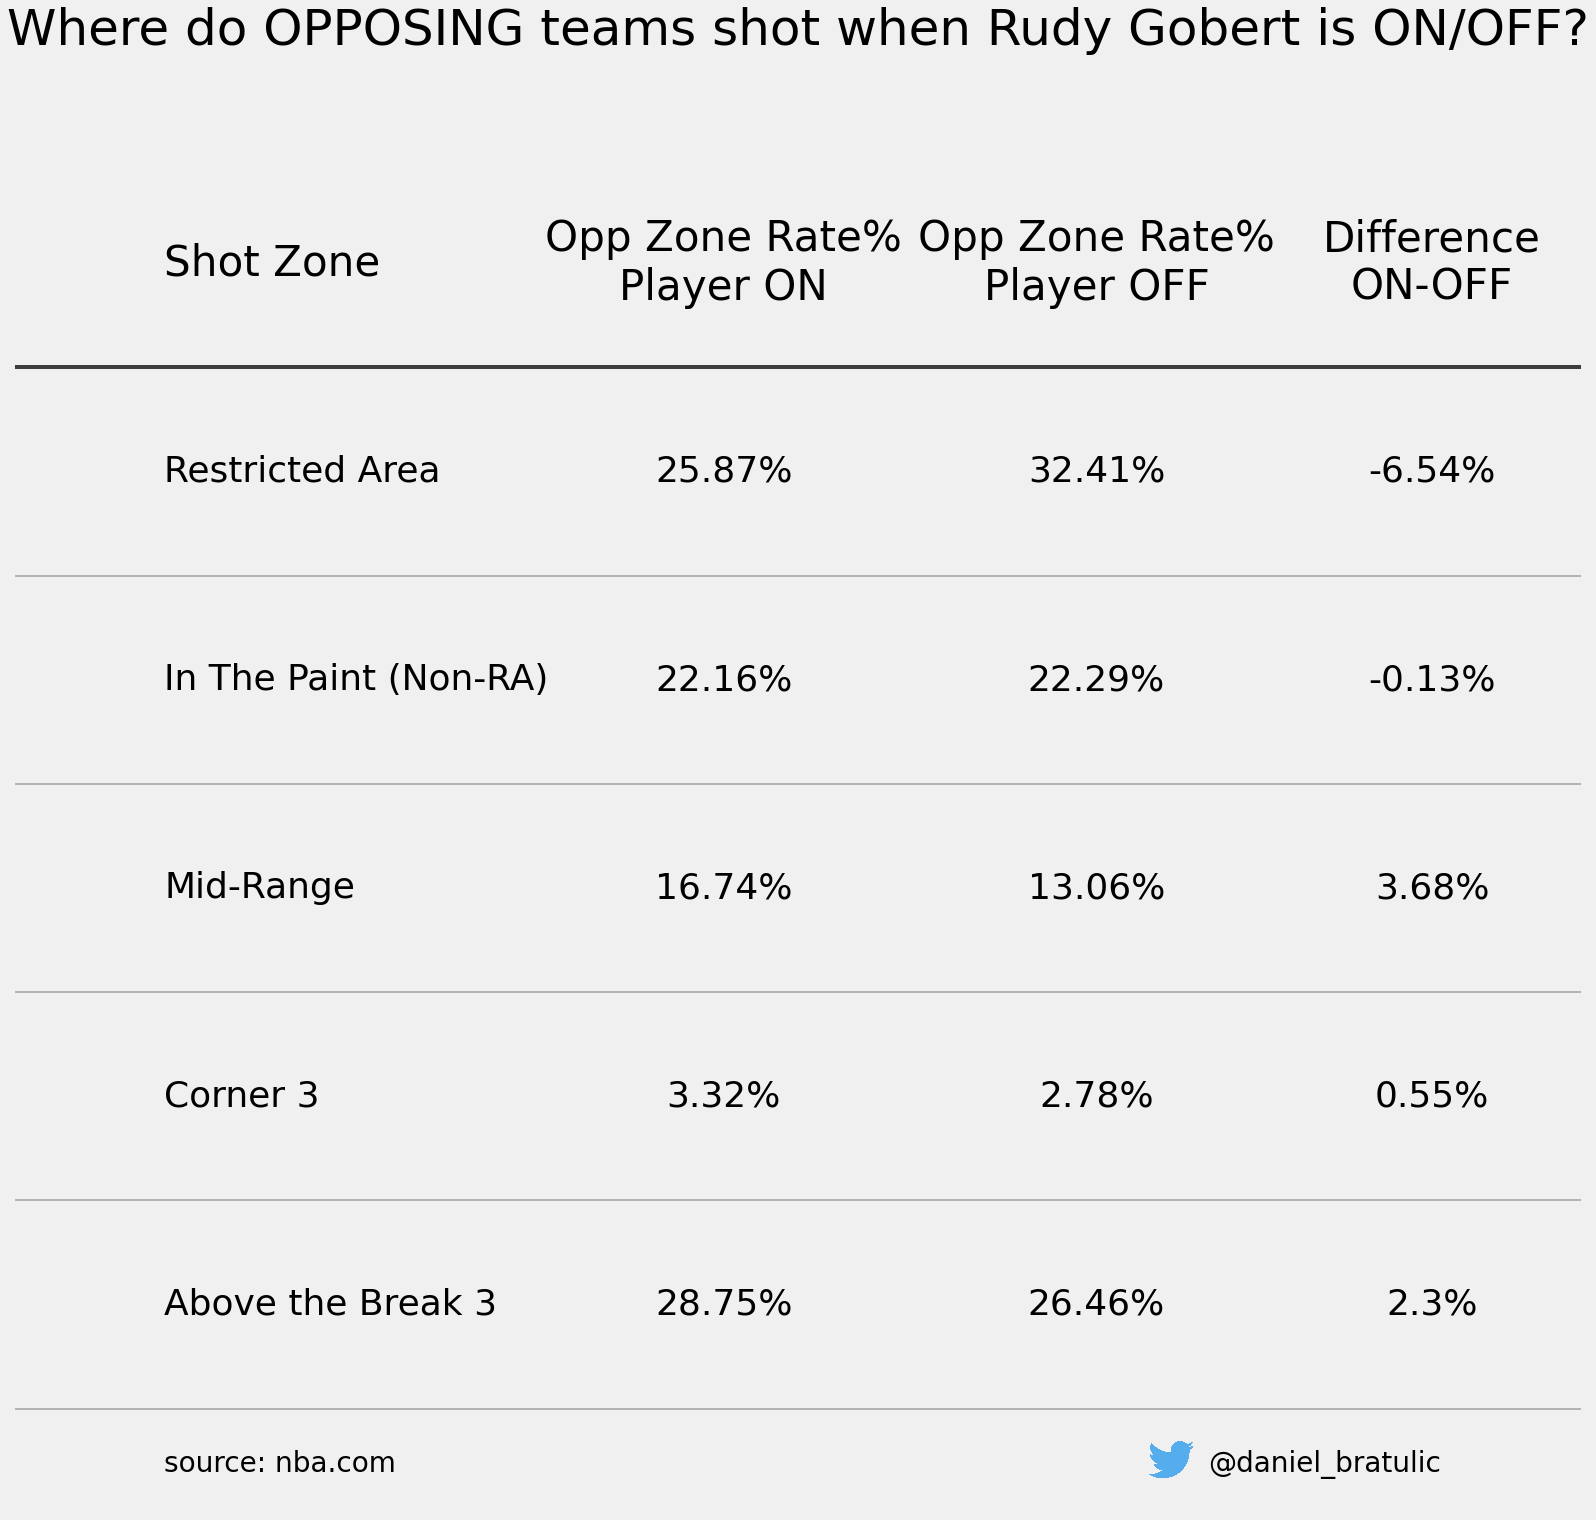

In [39]:
fig, ax = plt.subplots(figsize=(25, 25))
number_size = 36
font_size = 28
font_title = 42
title_size = 50
#top = 10

#sorted_open_df = ra_diff_sort
top = len(unique_keys)
for i in range(top):
    key = unique_keys[i]
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = '#EAE8E8'
    #    rect = Rectangle((-4.5, y_coord + 0.5), width=50, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=rev_mappings[key], size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=30, color='#A0A0A0', alpha=0.75, lw=2)

    ax.text(x=1.9, y=y_coord, ha='center', va='center', s=f"{rates[f'{key}_FG_RATE_ON']}%", size=number_size)
    ax.text(x=2.9, y=y_coord, ha='center', va='center', s=f"{rates[f'{key}_FG_RATE_OFF']}%", size=number_size)
    ax.text(x=3.8, y=y_coord, ha='center', va='center', s=f"{rates[f'{key}_FG_RATE_DIFF']}%", size=number_size)
    #ax.text(x=4.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_ON}%", size=number_size)
    #ax.text(x=5.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_OFF}%", size=number_size)
    #ax.text(x=6.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_DIFF:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)

ax.text(x=0.4, y=top, s='Shot Zone', ha='left', va='center', size=font_title)
ax.text(x=1.9, y=top, ha='center', va='center', s="Opp Zone Rate%\nPlayer ON", size=font_title)
ax.text(x=2.9, y=top, ha='center', va='center', s="Opp Zone Rate%\nPlayer OFF", size=font_title)
ax.text(x=3.8, y=top, ha='center', va='center', s="Difference\nON-OFF", size=font_title)
#ax.text(x=4.7, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player ON", size=font_title)
#ax.text(x=5.8, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player OFF", size=font_title)
#ax.text(x=6.7, y=top, ha='center', va='center', s="Difference \nin %", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=30, color='black', alpha=0.75, lw=4)
#ax.axvline(x=2.4, ymin=0.1, ymax=0.95, lw=2, color='black', ls='--')
ax.set_title("Where do OPPOSING teams shot when Rudy Gobert is ON/OFF?", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=4.2)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.04), (3.1, -0.75), frameon=False)
ax.add_artist(ab)
ax.text(x=3.2, y=-0.8, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.4, y=-0.8, ha='left', s='source: nba.com', size=28)
#ax.text(x=0.2, y=-1.2, s="RA FG% = Opponents' Field Goal% in Restricted Area", size=28)
#ax.text(x=0.2, y=-1.6, s="% of shots in RA = Ratio of total opponent's shots in Restricted Area", size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')    

## Roll Gravity

In [82]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes

In [87]:
pnr_man = SynergyPlayTypes(per_mode_simple='PerGame', player_or_team_abbreviation='P',type_grouping_nullable="offensive", play_type_nullable='PRRollman', season='2020-21').get_data_frames()[0]

In [93]:
top_pnr = pnr_man.sort_values(by='POSS', ascending=False).iloc[:22]

In [94]:
top_pnr

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,PLAY_TYPE,TYPE_GROUPING,PERCENTILE,GP,...,TOV_POSS_PCT,SF_POSS_PCT,PLUSONE_POSS_PCT,SCORE_POSS_PCT,EFG_PCT,POSS,PTS,FGM,FGA,FGMX
41,22020,202696,Nikola Vucevic,1610612741,CHI,Chicago Bulls,PRRollMan,Offensive,0.361,14,...,0.059,0.047,0.024,0.447,0.532,6.1,6.4,3.0,5.5,3.0
25,22020,200746,LaMarcus Aldridge,1610612759,SAS,San Antonio Spurs,PRRollMan,Offensive,0.307,21,...,0.025,0.025,0.000,0.462,0.513,5.7,5.8,2.9,5.4,2.9
2,22020,202696,Nikola Vucevic,1610612753,ORL,Orlando Magic,PRRollMan,Offensive,0.541,44,...,0.025,0.034,0.013,0.485,0.578,5.4,6.1,2.6,5.1,2.6
1,22020,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,PRRollMan,Offensive,0.741,57,...,0.066,0.045,0.008,0.541,0.650,4.2,5.2,1.6,3.8,1.6
8,22020,1626174,Christian Wood,1610612745,HOU,Houston Rockets,PRRollMan,Offensive,0.712,35,...,0.083,0.145,0.055,0.559,0.633,4.1,5.0,1.4,3.4,1.4
75,22020,1628976,Wendell Carter Jr.,1610612753,ORL,Orlando Magic,PRRollMan,Offensive,0.471,13,...,0.057,0.113,0.075,0.528,0.563,4.1,4.5,1.7,3.7,1.7
0,22020,203497,Rudy Gobert,1610612762,UTA,Utah Jazz,PRRollMan,Offensive,0.815,57,...,0.100,0.249,0.061,0.664,0.714,4.0,5.2,0.8,2.8,0.8
3,22020,1626158,Richaun Holmes,1610612758,SAC,Sacramento Kings,PRRollMan,Offensive,0.854,50,...,0.045,0.146,0.045,0.672,0.669,4.0,5.3,1.1,3.4,1.1
31,22020,201143,Al Horford,1610612760,OKC,Oklahoma City Thunder,PRRollMan,Offensive,0.220,28,...,0.027,0.009,0.000,0.400,0.491,3.9,3.8,2.3,3.8,2.3
7,22020,1627734,Domantas Sabonis,1610612754,IND,Indiana Pacers,PRRollMan,Offensive,0.239,53,...,0.114,0.144,0.060,0.458,0.506,3.8,3.7,1.6,3.0,1.6


In [95]:
top_pnr = top_pnr.loc[~top_pnr.PLAYER_NAME.isin(['Nikola Vucevic', 'LaMarcus Aldridge', 'Al Horford', 'Jarrett Allen', 'Anthony Davis', 'Wendell Carter Jr.'])]

In [97]:
player_teams = {}
for index in range(len(top_pnr)):
    item = top_pnr.iloc[index]
    player_teams[item.PLAYER_NAME] = find_team_by_abbreviation(item.TEAM_ABBREVIATION)['full_name']

In [40]:
player = "Rudy Gobert"
team = "Utah Jazz"

In [114]:
gobert_id = find_players_by_full_name(player)[0]['id']
team_id = find_teams_by_full_name(team)[0]['id']

In [102]:
#key = ['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_ZONE_BASIC']
key = ['SHOT_ZONE_BASIC']

offense_dfs = {}

for player in player_teams:
    if player == 'Isaiah Stewart':
        pl_id = 1630191
    else:
        pl_id = find_players_by_full_name(player)[0]['id']
    team_id = find_teams_by_full_name(player_teams[player])[0]['id']
    
    player_on_floor = get_on_floor(pl_id, full_df)
    player_off_floor = get_off_floor(pl_id, full_df)
    player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

    shot_off_court = pd.merge(left=shotchart_all, right=player_off_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    shot_on_court = pd.merge(left=shotchart_all, right=player_on_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    
    shot_on_court = shot_on_court.loc[shot_on_court.TEAM_ID == team_id]
    shot_off_court = shot_off_court.loc[shot_off_court.TEAM_ID == team_id]
    
    grouped_off = shot_off_court.groupby(key).sum().reset_index()
    grouped_off = grouped_off.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_off.loc[:, 'FG_PCT'] = grouped_off.SHOT_MADE_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG * 100
    grouped_off.loc[:, 'PCT_OF_SHOTS'] = grouped_off.SHOT_ATTEMPTED_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG.sum() * 100

    grouped_on = shot_on_court.groupby(key).sum().reset_index()
    grouped_on = grouped_on.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_on.loc[:, 'FG_PCT'] = grouped_on.SHOT_MADE_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG * 100
    grouped_on.loc[:, 'PCT_OF_SHOTS'] = grouped_on.SHOT_ATTEMPTED_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG.sum() * 100
    
    merged_defender_df = pd.merge(left=grouped_on, right=grouped_off, on=key, suffixes=('_ON', '_OFF'))
    offense_dfs[player] = merged_defender_df

In [103]:
mappings = {
    'Above the Break 3': 'ATB_3',
    'In The Paint (Non-RA)': 'PAINT',
    'Corner 3': 'CORNER',
    'Mid-Range': 'MID',
    'Restricted Area': 'RA',
}

final_data = []

for player in offense_dfs:
    df = offense_dfs[player]
    cur_dict = {
        'PLAYER': player
    }
    for key in mappings:
        if key == 'Corner 3':
            cur_df = df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')].iloc[0]
        else:
            cur_df = df.loc[df.SHOT_ZONE_BASIC == key].iloc[0]
        value = mappings[key]
        cur_dict[f"{value}_FG_RATE_ON"] = round(cur_df.PCT_OF_SHOTS_ON, 2)
        cur_dict[f"{value}_FG_RATE_OFF"] = round(cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_RATE_DIFF"] = round(cur_df.PCT_OF_SHOTS_ON - cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_PCT_ON"] = round(cur_df.FG_PCT_ON, 2)
        cur_dict[f"{value}_FG_PCT_OFF"] = round(cur_df.FG_PCT_OFF, 2)
        cur_dict[f"{value}_FG_PCT_DIFF"] = round(cur_df.FG_PCT_ON - cur_df.FG_PCT_OFF, 2)
    final_data.append(cur_dict)
   
print_df = pd.DataFrame(final_data)

In [106]:
print_df.loc[:, ['PLAYER'] + [column for column in print_df.columns if 'CORNER' in column]]

,PLAYER,CORNER_FG_RATE_ON,CORNER_FG_RATE_OFF,CORNER_FG_RATE_DIFF,CORNER_FG_PCT_ON,CORNER_FG_PCT_OFF,CORNER_FG_PCT_DIFF
0,Nikola Jokic,4.67,4.02,0.65,44.83,49.09,-4.26
1,Christian Wood,5.58,7.07,-1.49,37.17,43.06,-5.89
2,Rudy Gobert,6.46,6.63,-0.16,41.15,41.18,-0.03
3,Richaun Holmes,4.90,4.86,0.04,46.67,42.68,3.98
4,Domantas Sabonis,4.56,4.48,0.08,38.36,48.28,-9.91
5,Kristaps Porzingis,4.64,5.07,-0.43,39.00,35.09,3.91
6,Joel Embiid,4.77,4.10,0.68,37.50,25.53,11.97
7,Karl-Anthony Towns,5.32,4.83,0.50,43.44,29.79,13.66
8,Bam Adebayo,5.71,5.48,0.24,31.74,43.06,-11.32
9,Chris Boucher,4.95,5.96,-1.02,39.68,37.66,2.02


### Pick and Roll + Putback

In [135]:
player = "Rudy Gobert"
team = "Utah Jazz"

gobert_id = find_players_by_full_name(player)[0]['id']
team_id = find_teams_by_full_name(team)[0]['id']

In [136]:
gobert_id

203497

In [107]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict


In [108]:

def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


In [116]:
play_data = download_play_type_data('2020-21')

postup = play_data['OffRebound']
pnr = play_data['PRRollman']

In [117]:
postup = postup.groupby(('PLAYER_ID', 'PLAYER_NAME')).agg(
    {
        'POSS': 'mean',
        'PPP': 'mean',
        'PTS': 'mean'
    }
).reset_index()

pnr = pnr.groupby(('PLAYER_ID', 'PLAYER_NAME')).agg(
    {
        'POSS': 'mean',
        'PPP': 'mean',
        'PTS': 'mean'
    }
).reset_index()

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if __name__ == '__main__':


In [122]:
merged_df = pd.merge(left=postup, right=pnr, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_PUTBACK', '_PNR'))

merged_df.loc[:, 'TOTAL_POSS'] = merged_df.POSS_PUTBACK + merged_df.POSS_PNR

top_50 = merged_df.sort_values(by='TOTAL_POSS', ascending=False).iloc[:36]
top_50 = top_50.loc[top_50.PLAYER_NAME != 'Thomas Bryant']

In [124]:
top_50

,PLAYER_ID,PLAYER_NAME,POSS_PUTBACK,PPP_PUTBACK,PTS_PUTBACK,POSS_PNR,PPP_PNR,PTS_PNR,TOTAL_POSS
28,202696,Nikola Vucevic,1.55,1.0710,1.70,5.75,1.0910,6.25,7.30
63,203991,Clint Capela,3.90,1.1260,4.40,3.20,1.2200,3.90,7.10
65,203999,Nikola Jokic,2.40,1.3240,3.20,4.20,1.2310,5.20,6.60
49,203497,Rudy Gobert,2.30,1.3010,3.00,4.00,1.3010,5.20,6.30
24,202685,Jonas Valanciunas,3.50,1.2910,4.50,2.80,1.1380,3.10,6.30
22,202683,Enes Kanter,3.60,1.2360,4.40,2.40,1.1540,2.80,6.00
69,1626157,Karl-Anthony Towns,2.20,1.2880,2.80,3.40,1.2200,4.20,5.60
70,1626158,Richaun Holmes,1.60,1.1380,1.80,4.00,1.3480,5.30,5.60
84,1627734,Domantas Sabonis,1.80,1.0860,1.90,3.80,0.9850,3.70,5.60
102,1628386,Jarrett Allen,2.10,1.3465,2.80,3.25,1.2520,4.00,5.35


In [125]:
player_root_dir = 'player_imgs'

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(player_id, zoom=1.0):
    #print(path)
    return OffsetImage(plt.imread(f"{player_root_dir}/{player_id}.png"), zoom=zoom)


In [113]:
from matplotlib.patches import Circle, Rectangle, Arc

203497 203497


Text(0.8, 0.775, 'source: nba.com')

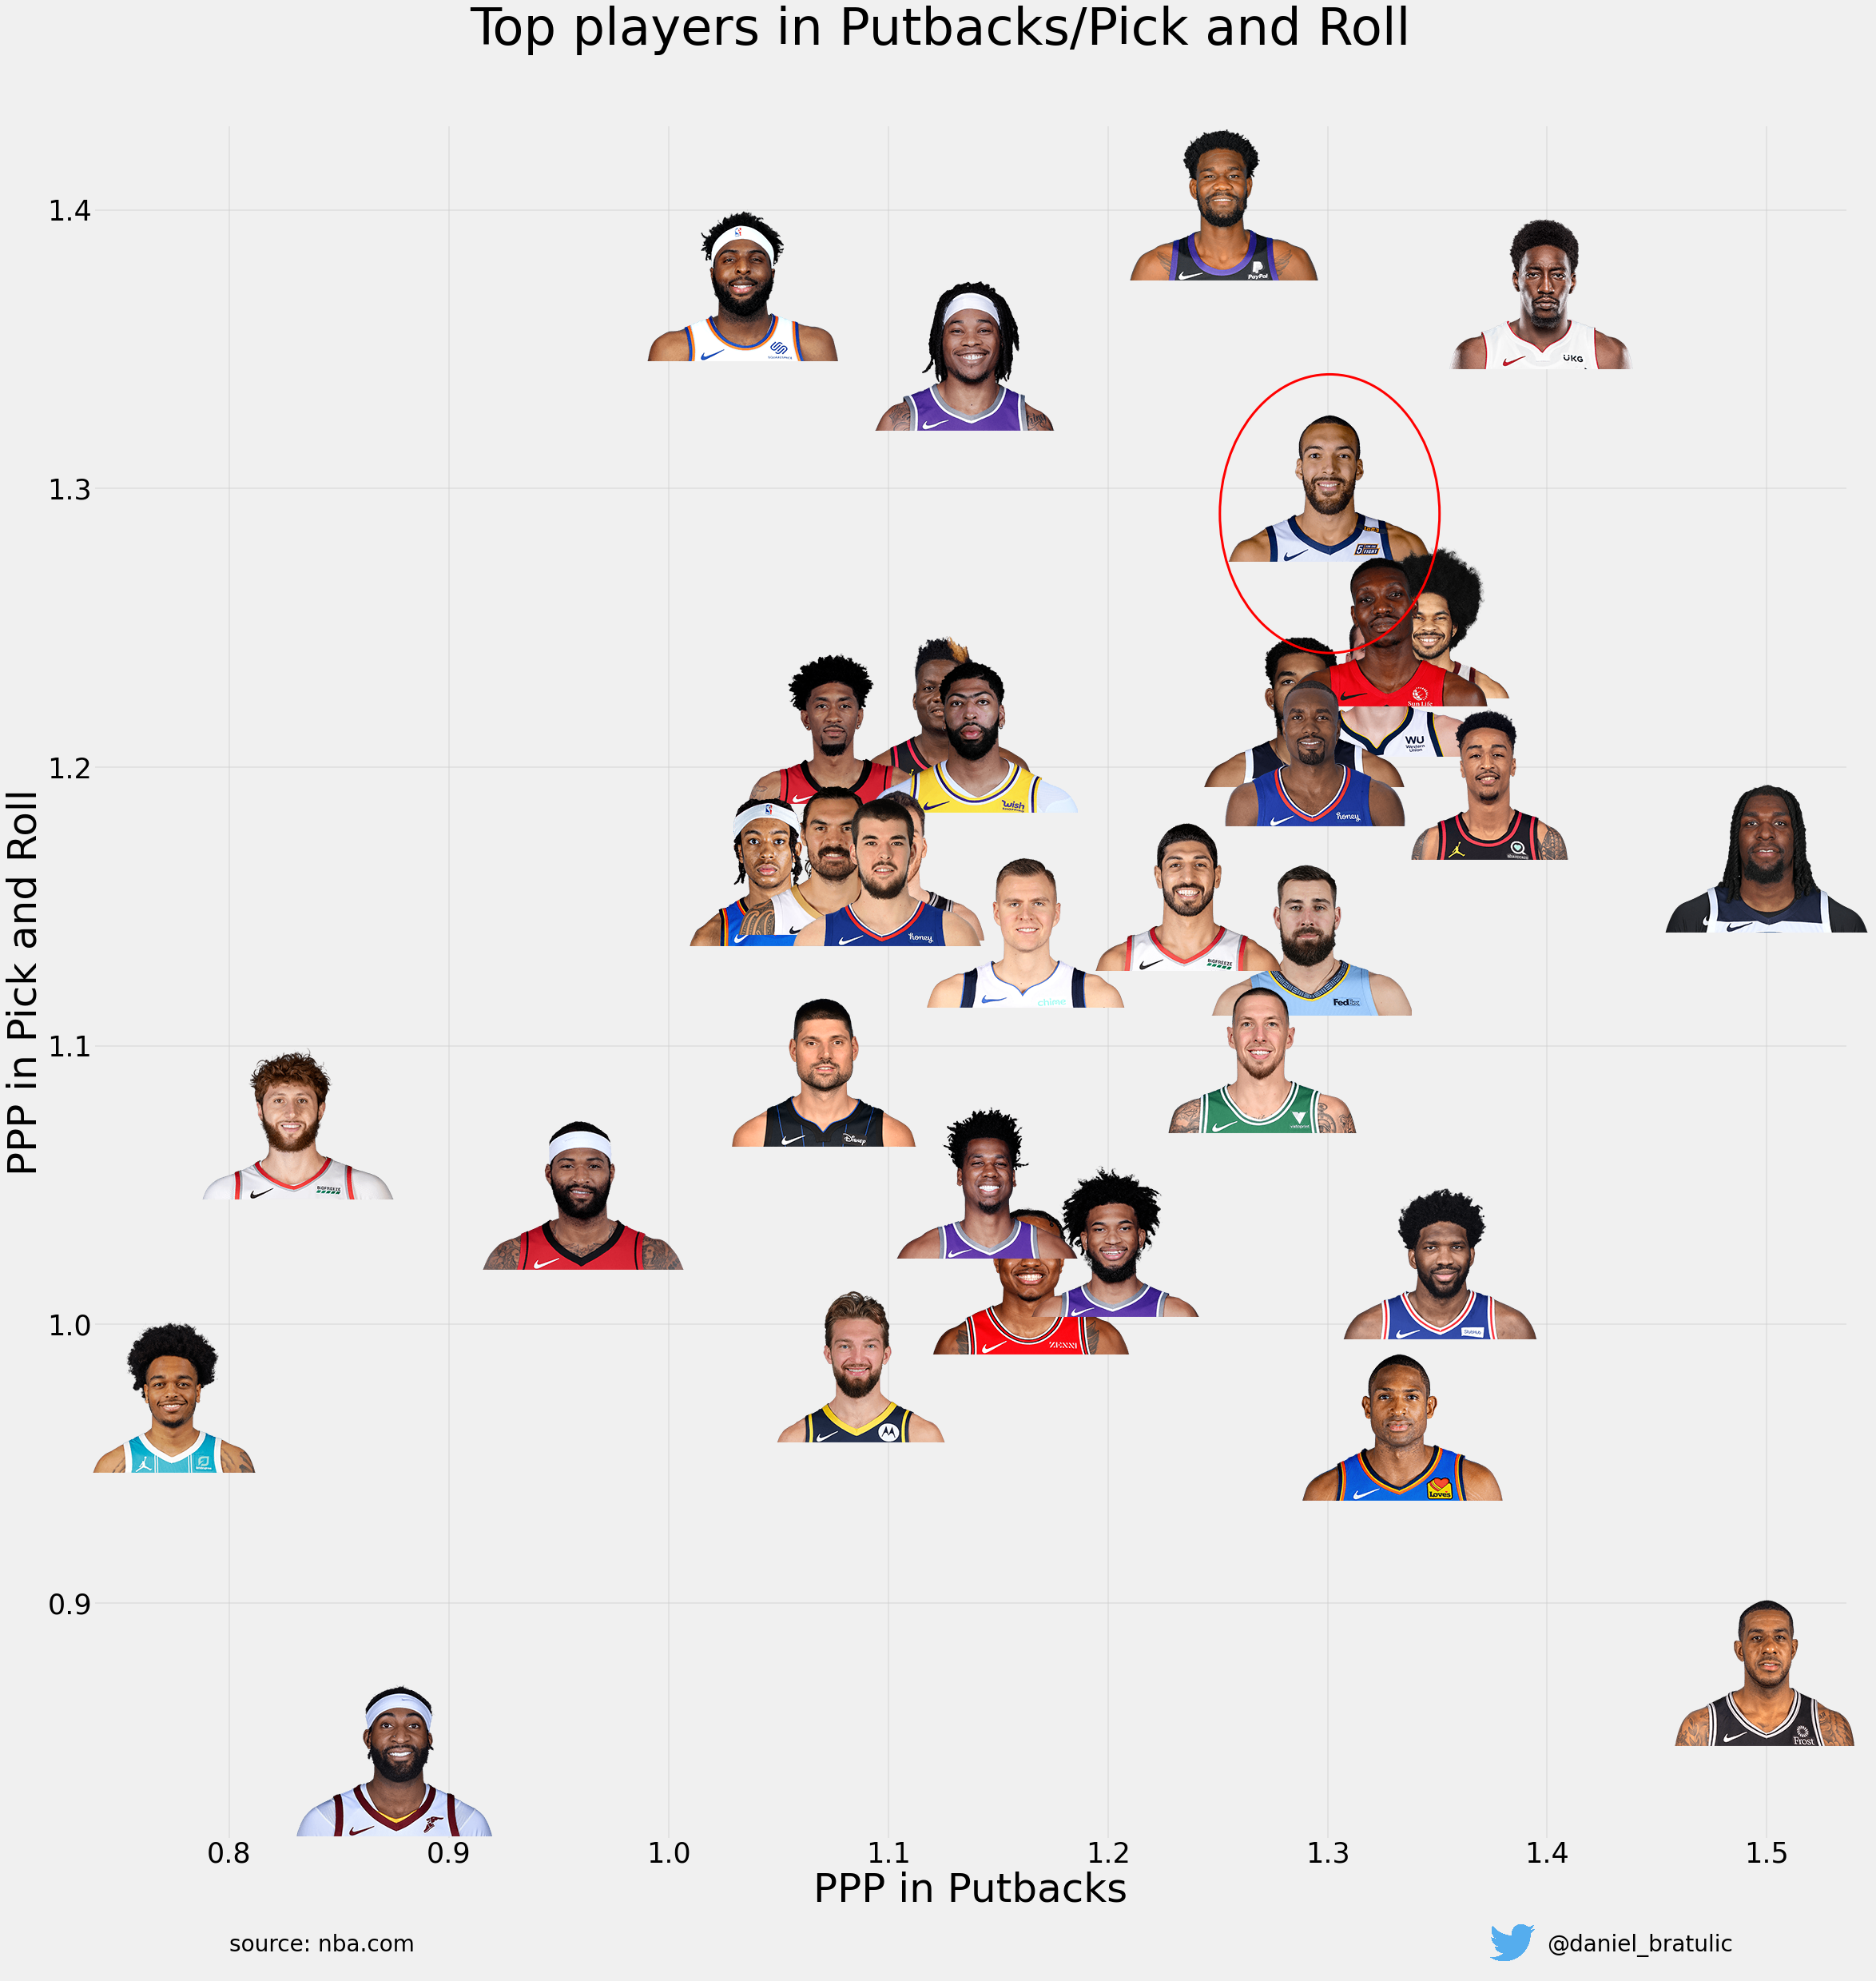

In [137]:
fig, ax = plt.subplots(figsize=(35, 35))
x = top_50.PPP_PUTBACK.tolist()
y = top_50.PPP_PNR.tolist()
ax.scatter(x, y) 
ax.tick_params(labelsize=35)
ax.set_xlabel("PPP in Putbacks", size=50)
ax.set_ylabel("PPP in Pick and Roll", size=50)
plt.suptitle("Top players in Putbacks/Pick and Roll", size=64)
#ax.set_title("Top 35 igrača s najviše posjeda u tim akcijama", size=50, ha='center')
#ax.set_ylim(0.7, 1.55)
#ax.set_xlim(-0.1, 10.1)
ax.grid(b=True, alpha=0.5, lw=1.5)

for x0, y0, player_id in zip(x, y, top_50.PLAYER_ID.tolist()):
    if player_id == gobert_id:
        print(player_id, gobert_id)
        ab = AnnotationBbox(getImage(player_id), (x0, y0), frameon=False, pad=0.0)
        circle = Circle((x0, y0-0.01), radius=0.05, linewidth=3, color='red', fill=False, zorder=6)
        ax.add_patch(circle)
    else:
        ab = AnnotationBbox(getImage(player_id), (x0, y0), frameon=False, pad=0.0)
    ax.add_artist(ab)
    
fig.subplots_adjust(top=0.92)
#ax.title.set_position([.5, 1.15])
ax.set_frame_on(False)

y_coord = 0.775
offset_image = OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05, )

#ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (0.88, 0.74), frameon=False)

offset_image.set_offset((1850, 5))
ax.add_artist(offset_image)
ax.text(x=1.4, y=y_coord, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.8, y=y_coord, ha='left', s='source: nba.com', size=28)